In [50]:
import mdtraj as md
import numpy as np
import os
from Bio import pairwise2


protein='AmyR'
#select folder created by parse_AF_output script
folder='results_dbscanseq_clusters'
pdb_GS='5f3k'
pdb_FS='5f5r'

In [51]:
fullMSA=md.load(folder+'/fullMSA_noH.pdb')
GS=md.load(pdb_GS+'.pdb')
FS=md.load(pdb_FS+'.pdb')



clusters = []

# Sort filenames numerically based on the number after 'clus'
def extract_cluster_number(filename):
    # Extract the number part from 'clusX.pdb'
    return int(filename[4:-4])

# Get the sorted list of filenames
sorted_filenames = sorted(
    [f for f in os.listdir(folder) if f.startswith('clus') and f.endswith('.pdb')],
    key=extract_cluster_number
)

for filename in sorted_filenames:
    cluster = md.load(os.path.join(folder, filename))
    clusters.append(cluster)

trajectory = clusters[0]
for cluster in clusters[1:]:
    trajectory += cluster

GS=md.load(pdb_GS+'.pdb')
FS=md.load(pdb_FS+'.pdb')

#load plDDT and cluster size values from the file written by get-pldtt-cluster_size.sh
plddt = np.load(folder+'/plddt.npy')
cl_size = np.load(folder+'/size.npy')

In [52]:
backbone_GS=[]
backbone_FS=[]
backbone_ref=[]
app=[]



# Dictionary to map three-letter codes to one-letter codes
three_to_one = {
    "ALA": "A", "ARG": "R", "ASN": "N", "ASP": "D", "CYS": "C",
    "GLU": "E", "GLN": "Q", "GLY": "G", "HIS": "H", "ILE": "I",
    "LEU": "L", "LYS": "K", "MET": "M", "PHE": "F", "PRO": "P",
    "SER": "S", "THR": "T", "TRP": "W", "TYR": "Y", "VAL": "V"
}


with open(folder+'/fullMSA_noH.pdb', 'r') as file:
    for index, line in enumerate(file):
        columns = line.strip().split()
        if len(columns) >= 4 and (columns[2] == "C"):
            backbone_ref.append(index+1)
            app.append(columns[3])
res_ref= "".join([three_to_one[aa] for aa in app])
app=[]
  

with open(pdb_GS+'.pdb', 'r') as file:
    for index, line in enumerate(file):
        columns = line.strip().split()
        if len(columns) >= 4 and (columns[2] == "C"):
            backbone_GS.append(index+1)
            app.append(columns[3])
            
res_GS= "".join([three_to_one[aa] for aa in app])
app=[]      

with open(pdb_FS+'.pdb', 'r') as file:
    for index, line in enumerate(file):
        columns = line.strip().split()
        if len(columns) >= 4 and (columns[2] == "C"):
            backbone_FS.append(index+1)
            app.append(columns[3])
            
res_FS= "".join([three_to_one[aa] for aa in app])      






In [53]:
alignments = pairwise2.align.globalxx(res_ref, res_GS)
ind_GS = [index for index, char in enumerate(alignments[0][1]) if char != '-']


In [54]:
alignments[0][0]

'AGHSTQTAEDKEEPLHSIISSTESVQGSTSKHEFQAETKKLLDIVARSLYSEKEVFIRELISNASDALEKLRHKLVSDGQALPEMEIHLQTNAEKGTITIQDTGIGMTQEELVSNLGTIARSGSKAFLDALQNQAEASSKIIGQFGVGFYSAFMVADRVEVYSRSAAPGSLGYQWLSDGSGVFEIAEASGVRTGTKIIIHLKSDCKEFSSEARVRDVVTKYSNFVSFPLYLNGRRMNT'

In [55]:
alignments[0][1]

'-------------------------QGSTSKHEFQAETKKLLDIVARSLYSEKEVFIRELISNASDALEKLRHKLVSDGQALPEMEIHLQTNAEKGTITIQDTGIGMTQEELVSNLGTIARSGSKAFLDAL--Q------IIGQFGVGFYSAFMVADRVEVYSRSAAPGSLGYQWLSDGSGVFEIAEASGVRTGTKIIIHLKSDCKEFSSEARVRDVVTKYSNFVSFPLYLNGRRMNT'

In [56]:
alignments = pairwise2.align.globalxx(res_ref, res_FS)
ind_FS = [index for index, char in enumerate(alignments[0][1]) if char != '-']

In [57]:
alignments[0][0]

'AGHSTQTAEDKEEPLHSIISSTESVQGSTSKHEFQAETKKLLDIVARSLYSEKEVFIRELISNASDALEKLRHKLVSDGQALPEMEIHLQTNAEKGTITIQDTGIGMTQEELVSNLGTIARSGSKAFLDALQNQAEASSKIIGQFGVGFYSAFMVADRVEVYSRSAAPGSLGYQWLSDGSGVFEIAEASGVRTGTKIIIHLKSDCKEFSSEARVRDVVTKYSNFVSFPLYLNGRRMNT'

In [58]:
alignments[0][1]

'-------------PLHSIISSTESVQGSTSKHEFQAETKKLLDIVARSLYSEKEVFIRELISNASDALEKLRHKLVS---ALPEMEIHLQTNAEKGTITIQDTGIGMTQEELVSNLGTIARSGSKAFLDALQNQAEASSKIIGQFGVGFYSAFMVADRVEVYSRSAAPGSLGYQWLSDGSGVFEIAEASGVRTGTKIIIHLKSDCKEFSSEARVRDVVTKYSNFVSFPLYLNGRRMNT'

In [59]:
rmsd_full_GS = md.rmsd(fullMSA, GS, atom_indices=np.array(backbone_ref)[np.array(ind_GS)], ref_atom_indices=np.array(backbone_GS))
rmsd_full_FS=md.rmsd(fullMSA, FS, atom_indices=np.array(backbone_ref)[np.array(ind_FS)], ref_atom_indices=np.array(backbone_FS))

In [60]:
rmsd_GS = md.rmsd(trajectory, GS, atom_indices=np.array(backbone_ref)[np.array(ind_GS)], ref_atom_indices=np.array(backbone_GS))
rmsd_FS = md.rmsd(trajectory, FS, atom_indices=np.array(backbone_ref)[np.array(ind_FS)], ref_atom_indices=np.array(backbone_FS))


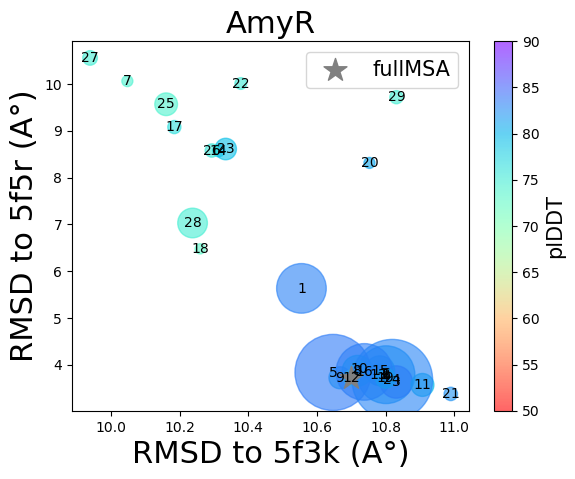

In [61]:
import matplotlib.pyplot as plt

plt.title(protein, fontsize=22)
sc = plt.scatter(rmsd_GS * 10, rmsd_FS * 10, c=plddt, cmap='rainbow_r', vmin=50, vmax=90, s=cl_size*3, alpha=0.6)
cbar = plt.colorbar(sc, label='plDDT')  # Create colorbar and set label

# Set font size for colorbar label
cbar.ax.yaxis.label.set_fontsize(15)

# Plotting a different marker for a specific point
plt.scatter(rmsd_full_GS * 10, rmsd_full_FS * 10, marker='*', s=300, label='fullMSA', color='grey')

for i, (x, y) in enumerate(zip(rmsd_GS * 10, rmsd_FS * 10)):
    plt.text(x, y, str(i+1), fontsize=10, ha='center', va='center', color='black')

# Adding dashed lines
#plt.axhline(y=4, color='black', linestyle='--')
#plt.axvline(x=4, color='black', linestyle='--')

# Setting limits and ticks for both axes
#plt.xlim([0, 23])
#plt.ylim([7, 22])
#plt.xticks([4,8,12,16], fontsize=22)
#plt.yticks([4,8,12,16], fontsize=22)

# Adding labels and legend
plt.xlabel('RMSD to '+pdb_GS+' (A°)', fontsize=22)
plt.ylabel('RMSD to '+pdb_FS+' (A°)', fontsize=22)
plt.legend(fontsize=15)

plt.show()

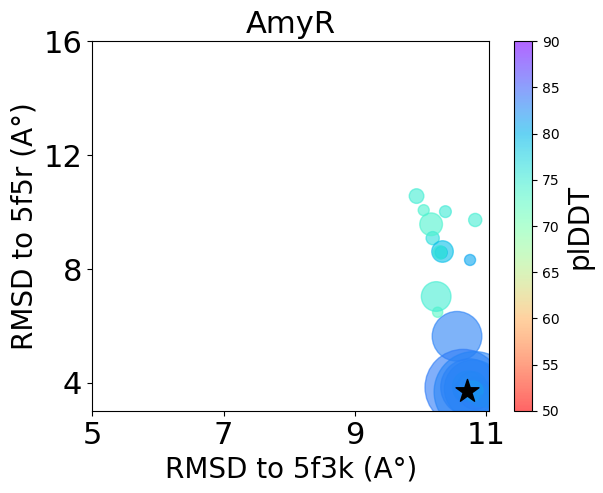

In [62]:
plt.title(protein, fontsize=22)
sc = plt.scatter(rmsd_GS * 10, rmsd_FS * 10, c=plddt, cmap='rainbow_r', vmin=50, vmax=90, s=cl_size*3, alpha=0.6)
cbar = plt.colorbar(sc, label='plDDT')  # Create colorbar and set label

# Set font size for colorbar label
cbar.ax.yaxis.label.set_fontsize(20)

# Plotting a different marker for a specific point
plt.scatter(rmsd_full_GS * 10, rmsd_full_FS * 10, marker='*', s=300, label='fullMSA', color='black')


# Adding dashed lines
#plt.axhline(y=4, color='black', linestyle='--')
#plt.axvline(x=4, color='black', linestyle='--')

# Setting limits and ticks for both axes
#plt.xlim([0, 23])
#plt.ylim([7, 22])
plt.xticks([5,7,9,11], fontsize=22)
plt.yticks([4,8,12,16], fontsize=22)

# Adding labels and legend
plt.xlabel('RMSD to '+pdb_GS+' (A°)', fontsize=20)
plt.ylabel('RMSD to '+pdb_FS+' (A°)', fontsize=20)
#plt.legend(fontsize=15)

plt.show()

In [63]:
np.where(rmsd_GS<0.5)[0]+1

array([], dtype=int64)

In [64]:
np.where(rmsd_FS<0.5)[0]+1

array([ 2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 15, 16, 19, 21, 24])

In [65]:
np.save(folder+'/cluster_ids_fullMSA_state',np.where(rmsd_FS<1.2)[0]+1)
np.save(folder+'/cluster_ids_alternative_state',np.where(rmsd_GS<0.9)[0]+1)